In [2]:
import requests
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import mstats
from scipy.signal import argrelextrema
from scipy import signal
from tqdm import tqdm
import asyncio
import aiohttp
import warnings
from pykalman import KalmanFilter as pyKalmanFilter

# Machine Learning Libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras import callbacks
import talib
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

import calc_functions as u
import feature_generation as fg


In [3]:
# LIST OF BINANCE URLS AVAIL
# GET /api/v3/klines
# GET /api/v3/uiKlines
# <symbol>@miniTicker
# <symbol>@ticker

# data format for reference
# [
#   [
#     1499040000000,      // Kline open time
#     "0.01634790",       // Open price
#     "0.80000000",       // High price
#     "0.01575800",       // Low price
#     "0.01577100",       // Close price
#     "148976.11427815",  // Volume
#     1499644799999,      // Kline Close time
#     "2434.19055334",    // Quote asset volume
#     308,                // Number of trades
#     "1756.87402397",    // Taker buy base asset volume
#     "28.46694368",      // Taker buy quote asset volume
#     "0"                 // Unused field, ignore.
#   ]
# ]

base_url = "https://api.binance.com/api/v3/klines"

# Function to fetch hourly data from Binance
def fetch_binance_data(symbol, interval, start_time, end_time):
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': int(start_time.timestamp() * 1000),
        'endTime': int(end_time.timestamp() * 1000),
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

# Function to convert Binance data to DataFrame
def binance_data_to_dataframe(data):
    # From klines in binance API
    df = pd.DataFrame(data, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 
                                     'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 
                                     'Taker Buy Quote Asset Volume', 'Ignore'])
    
    # Convert timestamp to datetime
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')
    # remove IGNORE column 
    df = df.drop(columns=['Ignore'])
    return df

# Parameters set
symbol = "BTCUSDT"
interval = "1h"
end_time = datetime.now()
start_time = end_time - relativedelta(months=60)  # 3 months ago, either this or 90 days

btcusdt_data = pd.DataFrame()

# There is a limit of 500 fetches per query, hence I used a loop to fetch data for past 3 months
while start_time < end_time:
    fetched_data = fetch_binance_data(symbol, interval, start_time, end_time)
    
    df = binance_data_to_dataframe(fetched_data)

    if not df.empty:
        btcusdt_data = pd.concat([btcusdt_data, df])
        start_time = pd.to_datetime(df['Close Time'].iloc[-1]) + timedelta(hours=1)
    else:
        break
        
btcusdt_data = btcusdt_data.reset_index(drop=True)
btcusdt_data = btcusdt_data.drop(columns=['Close Time'])
btcusdt_data.to_csv('./BTCUSDT_Hourly.csv', index=True) 

columns_to_convert = {
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Volume': float,
    'Quote Asset Volume': float,
    'Number of Trades': int,
    'Taker Buy Base Asset Volume': float,
    'Taker Buy Quote Asset Volume': float
}

btcusdt_data = btcusdt_data.astype(columns_to_convert)
btcusdt_data = btcusdt_data.set_index(['Open Time'])
btcusdt_data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume
Open Time,,,,,,,,,
2018-12-19 07:00:00,3719.44,3719.99,3652.00,3698.31,2735.449233,1.008120e+07,13178,1274.688245,4.696710e+06
2018-12-19 08:00:00,3699.59,3721.50,3683.95,3721.00,1909.793360,7.077461e+06,9895,1025.602986,3.800314e+06
2018-12-19 09:00:00,3721.45,3759.00,3712.79,3721.64,3496.068083,1.306161e+07,15080,1696.728887,6.338845e+06
2018-12-19 10:00:00,3721.70,3794.00,3711.60,3774.69,3801.054909,1.429946e+07,16520,2014.101538,7.573831e+06
2018-12-19 11:00:00,3774.40,3830.00,3772.02,3821.40,5370.042385,2.043487e+07,26424,2442.935341,9.295473e+06
...,...,...,...,...,...,...,...,...,...
2023-12-19 02:00:00,43314.99,43497.00,43031.11,43076.71,2352.658980,1.016203e+08,76966,1200.314890,5.184931e+07
2023-12-19 03:00:00,43076.71,43136.00,42993.62,43082.20,1318.283640,5.676046e+07,48487,642.920540,2.768397e+07
2023-12-19 04:00:00,43082.21,43131.20,42840.04,42921.47,1453.740120,6.250459e+07,55069,668.932240,2.876562e+07


In [4]:
# end_time = datetime.now()
# start_time = end_time + relativedelta(days=90)
# start_time

In [5]:
# Attempt at using asyncio

# base_url = "https://api.binance.com/api/v3/klines"

# # Asynchronous function to fetch data from Binance
# async def fetch_binance_data(session, symbol, interval, start_time, end_time):
#     params = {
#         'symbol': symbol,
#         'interval': interval,
#         'startTime': int(start_time.timestamp() * 1000),
#         'endTime': int(end_time.timestamp() * 1000),
#     }
#     async with session.get(base_url, params=params) as response:
#         data = await response.json()
#         return data

# # Function to convert Binance data to DataFrame
# def binance_data_to_dataframe(data):
#     df = pd.DataFrame(data, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
#                                      'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
#                                      'Taker Buy Quote Asset Volume', 'Ignore'])
#     df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
#     df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')
#     df = df.drop(columns=['Ignore'])
#     return df

# async def main():
#     symbol = "BTCUSDT"
#     interval = "1h"
#     end_time = datetime.now()
#     start_time = end_time - relativedelta(months=12)  # 12 months ago

#     tasks = []
#     btcusdt_data = pd.DataFrame()

#     # Create an aiohttp session
#     async with aiohttp.ClientSession() as session:
#         while start_time < end_time:
#             # Calculate next time
#             next_time = start_time + timedelta(hours=500)  # 500 hours later
#             if next_time > end_time:
#                 next_time = end_time

#             # Schedule the fetch task
#             tasks.append(fetch_binance_data(session, symbol, interval, start_time, next_time))
#             start_time = next_time + timedelta(hours=1)

#         responses = await asyncio.gather(*tasks)

#         # Process each response
#         for fetched_data in responses:
#             df = binance_data_to_dataframe(fetched_data)
#             if not df.empty:
#                 btcusdt_data = pd.concat([btcusdt_data, df])

#     # Convert columns to appropriate data types
#     columns_to_convert = {
#         'Open': float,
#         'High': float,
#         'Low': float,
#         'Close': float,
#         'Volume': float,
#         'Quote Asset Volume': float,
#         'Number of Trades': int,
#         'Taker Buy Base Asset Volume': float,
#         'Taker Buy Quote Asset Volume': float
#     }

#     btcusdt_data = btcusdt_data.astype(columns_to_convert)
#     btcusdt_data = btcusdt_data.set_index(['Open Time'])
#     btcusdt_data = btcusdt_data.drop(columns=['Close Time'])

#     # Save to CSV
#     btcusdt_data.to_csv('./BTCUSDT_Hourly.csv', index=True) 
#     print("Data saved to BTCUSDT_Hourly.csv")
    
# if __name__ == "__main__":
#     loop = asyncio.get_event_loop()
#     loop.run_until_complete(main())


In [6]:
# async def count():
#     print("count one")
#     await asyncio.sleep(1)
#     print("count four")

# async def count_further():
#     print("count two")
#     await asyncio.sleep(1)
#     print("count five")

# async def count_even_further():
#     print("count three")
#     await asyncio.sleep(1)
#     print("count six")

# async def main():
#     await asyncio.gather(count(), count_further(), count_even_further())

# s = time.perf_counter()
# await main()
# elapsed = time.perf_counter() - s
# print(f"Script executed in {elapsed:0.4f} seconds.")

In [10]:
# Calculate Moving Averages (MA)
btcusdt_data['SMA_10'] = talib.SMA(btcusdt_data['Close'], timeperiod=10)
btcusdt_data['SMA_50'] = talib.SMA(btcusdt_data['Close'], timeperiod=50)

# Calculate Relative Strength Index (RSI)
btcusdt_data['RSI_14'] = talib.RSI(btcusdt_data['Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
macd, signal, _ = talib.MACD(btcusdt_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
btcusdt_data['MACD'] = macd
btcusdt_data['MACD_Signal'] = signal

# Calculate Bollinger Bands (BB)
upper, middle, lower = talib.BBANDS(btcusdt_data['Close'], timeperiod=20)
btcusdt_data['BB_Upper'] = upper
btcusdt_data['BB_Middle'] = middle
btcusdt_data['BB_Lower'] = lower

# Calculate Momentum (MOM)
btcusdt_data['MOM_10'] = talib.MOM(btcusdt_data['Close'], timeperiod=10)

# Calculate Stochastic Oscillator (KD)
slowk, slowd = talib.STOCH(btcusdt_data['High'], btcusdt_data['Low'], btcusdt_data['Close'])
btcusdt_data['SlowK'] = slowk
btcusdt_data['SlowD'] = slowd

# Calculate Average Directional Index (ADX)
btcusdt_data['ADX_14'] = talib.ADX(btcusdt_data['High'], btcusdt_data['Low'], btcusdt_data['Close'], timeperiod=14)

# Include prev_close price
btcusdt_data['prev_close'] = btcusdt_data['Close'].shift(1)
btcusdt_data['RC'] = btcusdt_data['Close'].transform(lambda x: x.pct_change(periods = 15)) 

# You now have the calculated indicators in your DataFrame btcusdt_data
btcusdt_data = btcusdt_data.dropna()
btcusdt_data 

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,SMA_10,...,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha18,alpha19,alpha20
Open Time,,,,,,,,,,,,,,,,,,,,,
2018-12-29 17:00:00,3789.38,3801.75,3771.00,3795.06,1435.671362,5.433952e+06,9019,739.054031,2.797979e+06,3814.850,...,0.796135,5.68,-0.075155,-0.316091,0.324834,-0.060431,-0.131890,-0.400481,-1.626321,-0.094868
2018-12-29 18:00:00,3796.25,3805.50,3771.37,3791.85,848.202347,3.216832e+06,6654,488.402927,1.852657e+06,3808.945,...,0.693479,-3.21,-0.136524,-0.185724,0.334343,-0.258347,-0.015612,-0.333837,1.598388,-0.244977
2018-12-29 19:00:00,3791.86,3798.17,3778.04,3793.31,669.497216,2.536458e+06,6087,378.866894,1.435117e+06,3804.349,...,0.496079,1.46,-0.201649,-0.533408,-0.949352,-0.766774,-0.023564,-0.382068,1.599332,-0.140396
2018-12-29 20:00:00,3794.49,3830.10,3792.33,3810.13,1227.641591,4.681035e+06,9267,666.589853,2.541894e+06,3806.458,...,0.673245,-16.82,-0.365766,-0.184073,-2.179302,-0.831463,-0.156754,-0.472507,1.553253,-0.166871
2018-12-29 21:00:00,3810.06,3876.47,3808.81,3859.59,2568.056588,9.893990e+06,16378,1479.490761,5.700593e+06,3811.957,...,0.920717,-49.46,-0.965079,-0.355271,-2.297968,-0.949622,-0.538830,-0.631856,-1.556408,-0.023376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19 02:00:00,43314.99,43497.00,43031.11,43076.71,2352.658980,1.016203e+08,76966,1200.314890,5.184931e+07,42359.518,...,0.833299,-238.28,-0.934623,-0.053556,-2.276418,-0.876643,-0.005366,-0.179228,-1.351986,-0.196831
2023-12-19 03:00:00,43076.71,43136.00,42993.62,43082.20,1318.283640,5.676046e+07,48487,642.920540,2.768397e+07,42529.237,...,0.555989,5.49,-0.862125,-0.114126,-2.066611,-0.826700,-0.085483,-0.857002,-1.345538,-0.012577
2023-12-19 04:00:00,43082.21,43131.20,42840.04,42921.47,1453.740120,6.250459e+07,55069,668.932240,2.876562e+07,42657.041,...,0.502651,160.73,-0.843852,0.001045,-2.056187,-0.776574,-0.028778,-0.648895,-1.337271,-0.238139


In [11]:
# Create alpha factors
df = btcusdt_data[btcusdt_data.columns[:5]]
df.columns = df.columns.str.lower()
btcusdt_data['vwap'] = u.vwap(df)
btcusdt_data['returns'] = u.returns(df)
df['vwap'] = u.vwap(df)
df['returns'] = u.returns(df)
btcusdt_data = btcusdt_data.dropna()
df = df.dropna()

unavailable = {48, 56, 58, 59, 63, 67, 69, 70, 76, 79, 80, 82, 87, 89, 90, 91, 93, 97, 100}

for n in tqdm(range(101), desc="Processing Alphas"):
    if n+1 in unavailable:
        pass
    else:
        name = 'alpha{}'.format(n+1)
        func = 'fg.{}'.format(name)
        temp_func = eval(func)
        btcusdt_data[name] = temp_func(df)
btcusdt_data = btcusdt_data.dropna()
btcusdt_data

Processing Alphas: 100%|████████████████████████| 101/101 [01:59<00:00,  1.18s/it]


,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,SMA_10,...,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,alpha101
Open Time,,,,,,,,,,,,,,,,,,,,,
2019-01-09 04:00:00,3981.98,4002.00,3981.03,3994.00,928.313063,3.704281e+06,8104,431.214492,1.721117e+06,3971.254,...,0.970880,0,0.162778,0.157895,-0.656434,True,0.538462,-0.046530,-0.257762,0.573172
2019-01-09 05:00:00,3994.00,3999.20,3983.00,3987.98,802.910191,3.203398e+06,7068,411.094666,1.640035e+06,3973.206,...,0.992383,0,0.185279,0.105263,-0.406482,True,0.538462,0.004548,-0.088331,-0.371582
2019-01-09 06:00:00,3988.19,3990.00,3978.00,3986.63,801.934331,3.195489e+06,6799,403.355502,1.607392e+06,3974.257,...,0.993722,0,0.212823,0.052632,-0.633128,True,0.538462,0.022046,-0.139971,-0.129989
2019-01-09 07:00:00,3986.44,4000.00,3985.02,3987.88,797.726342,3.184855e+06,7428,374.056175,1.493403e+06,3976.505,...,0.991212,0,0.219088,0.052632,-0.637257,True,0.625000,0.049545,-0.044338,0.096122
2019-01-09 08:00:00,3987.76,3991.78,3971.11,3982.54,1076.596718,4.288753e+06,8026,628.774013,2.505016e+06,3978.436,...,0.986737,0,0.241151,0.052632,-0.619164,True,0.538462,0.062225,-0.425511,-0.252528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19 00:00:00,42657.80,42900.00,42567.69,42713.96,2327.756320,9.939719e+07,74585,1226.475710,5.237348e+07,41996.543,...,0.967658,0,0.256028,0.052632,-0.984765,True,0.875000,0.687338,-0.719349,0.168998
2023-12-19 03:00:00,43076.71,43136.00,42993.62,43082.20,1318.283640,5.676046e+07,48487,642.920540,2.768397e+07,42529.237,...,0.929890,0,0.241220,0.263158,-0.968417,True,0.875000,0.701085,-0.601230,0.038559
2023-12-19 04:00:00,43082.21,43131.20,42840.04,42921.47,1453.740120,6.250459e+07,55069,668.932240,2.876562e+07,42657.041,...,0.905201,-1,0.307271,0.736842,-0.973485,True,1.000000,0.642361,-0.506472,-0.552066


In [12]:
btcusdt_data.replace([np.inf, -np.inf], np.nan, inplace=True)

nan_count = btcusdt_data.isna().sum()
problematic_columns = []
for i in range(len(nan_count)):
    col = nan_count.index[i]
    count = nan_count[i]
    if count != 0:
        problematic_columns.append(col)
        print(col, count)
        
btcusdt_data = btcusdt_data.drop(columns=problematic_columns)

alpha45 3
alpha53 198
alpha71 82
alpha84 3107


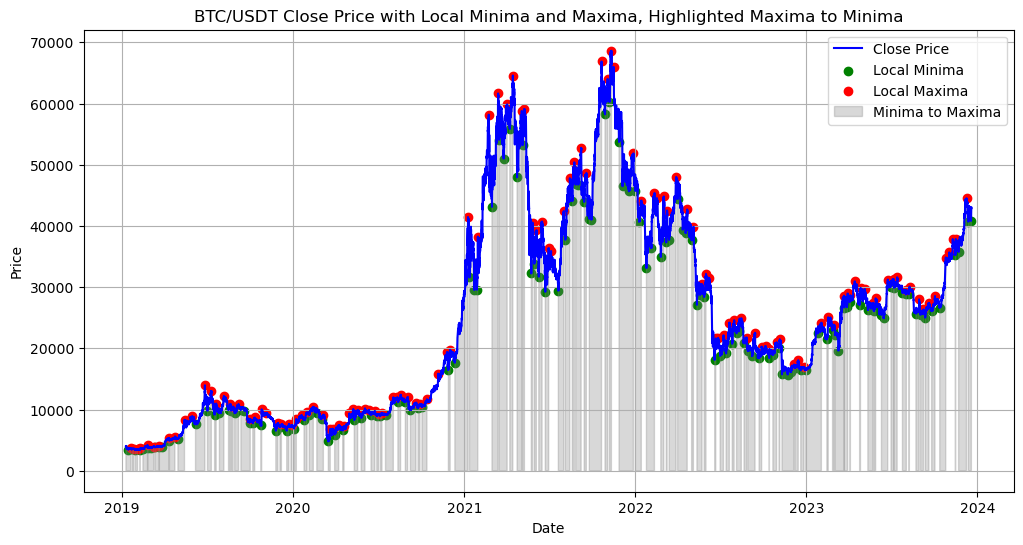

In [13]:
# Function to find local minima and maxima using argrelextrema
def find_local_min_max(data, order=10):
    # Find local minima
    local_minima_indices = argrelextrema(data.values, np.less, order=order)[0]
    local_minima = [(i, data[i]) for i in local_minima_indices]

    # Find local maxima
    local_maxima_indices = argrelextrema(data.values, np.greater, order=order)[0]
    local_maxima = [(i, data[i]) for i in local_maxima_indices]

    return local_minima, local_maxima
    
local_minima, local_maxima = find_local_min_max(btcusdt_data['Close'], 100)

# We will now create the new column as per the instructions
# Initialize the new column with zeros
btcusdt_data['label'] = 1

# Function to set values between minima and maxima
def set_values_between_extrema(data, minima_indices, maxima_indices):
    # Sort the extrema indices
    extrema_indices = sorted(minima_indices + maxima_indices)
    
    # Set values between a maxima and the next minima to 1
    for i in range(len(extrema_indices) - 1):
        if extrema_indices[i] in maxima_indices:
            data['label'].iloc[extrema_indices[i]:extrema_indices[i + 1]] = 0
    
    # Handle the last segment after the last extremum
    last_extremum = extrema_indices[-1]
    if last_extremum in maxima_indices:
        data['label'].iloc[last_extremum:] = 0

# Extract indices from local minima and maxima
minima_indices, _ = zip(*local_minima)
maxima_indices, _ = zip(*local_maxima)
minima_indices = list(minima_indices)
maxima_indices = list(maxima_indices)

# Set the values between minima and maxima according to the rules
set_values_between_extrema(btcusdt_data, minima_indices, maxima_indices)

# Display the updated DataFrame
btcusdt_data.head()

# Function to plot the data with the new column visualized
def plot_with_new_column(data, minima_indices, maxima_indices):
    plt.figure(figsize=(12, 6))
    
    # Plot the 'Close' data
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    
    # Plot local minima and maxima points
    plt.scatter(data.index[minima_indices], data['Close'].iloc[minima_indices], marker='o', color='green', label='Local Minima')
    plt.scatter(data.index[maxima_indices], data['Close'].iloc[maxima_indices], marker='o', color='red', label='Local Maxima')
    
    # Highlight areas where the new column is 1
    maxima_to_minima_regions = data['label'] == 1
    plt.fill_between(data.index, data['Close'], where=maxima_to_minima_regions, color='gray', alpha=0.3, label='Minima to Maxima')
    
    plt.title('BTC/USDT Close Price with Local Minima and Maxima, Highlighted Maxima to Minima')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Call the plot function
plot_with_new_column(btcusdt_data, minima_indices, maxima_indices)



In [691]:
# %%time
# from scipy import signal

# def get_savgol(close, window = 110, polyorder = 3):
#     smoothed = signal.savgol_filter(close, window_length = window, polyorder = polyorder)
#     # Use a Kalman filter to further smooth the predictions
#     observation_matrix = np.identity(1)
#     initial_state_mean = np.mean(smoothed)
#     initial_state_covariance = np.cov(smoothed)
#     transition_matrix = np.array([[1]])
#     process_noise_covariance = np.array([[1e-5]])
#     observation_noise_covariance = np.array([[1e-3]])
#     kf = pyKalmanFilter(
#         transition_matrices=transition_matrix,
#         observation_matrices=observation_matrix,
#         initial_state_mean=initial_state_mean,
#         initial_state_covariance=initial_state_covariance,
#         #process_noise_covariance=process_noise_covariance
#     )
#     filtered_state_means, filtered_state_covariances = kf.filter(smoothed)
#     #print(filtered_state_means.flatten())
#     return filtered_state_means.flatten()

# window = 500
# t1 = get_savgol(btcusdt_data['Close'], window)#[:-window]
# t2 = pd.Series(t1).shift(1)
# res = (t1 - t2)
# res = [1 if x > 0 else 0 for x in res]
# btcusdt_data['signal'] = res

# plt.figure(figsize=(12, 6))

# # Plot the close prices
# plt.plot(btcusdt_data.index, btcusdt_data['Close'], label='Close', color='blue')

# # Plot the signal with green and red dots
# for i in range(1, len(btcusdt_data)):
#     if btcusdt_data['signal'][i] == 1 and btcusdt_data['signal'][i - 1] == 0:
#         plt.scatter(btcusdt_data.index[i], btcusdt_data['Close'][i], color='green', marker='o', label='Buy Signal')
#     elif btcusdt_data['signal'][i] == 0 and btcusdt_data['signal'][i - 1] == 1:
#         plt.scatter(btcusdt_data.index[i], btcusdt_data['Close'][i], color='red', marker='o', label='Sell Signal')

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Close Price with Buy/Sell Signals')
# plt.grid(True)
# plt.show()


In [14]:
btcusdt_data = btcusdt_data.dropna().copy()

# Winsorising to prevent large values from causing bias
Target_variables = btcusdt_data.columns[9:]
for variable in Target_variables:
    btcusdt_data.loc[:,variable] = mstats.winsorize(btcusdt_data.loc[:,variable], limits = [0.1,0.1])

# Check for infinity or too large values in each column
problematic_columns = []
for column in btcusdt_data.columns:
    is_inf = np.isinf(btcusdt_data[column])
    is_large = btcusdt_data[column] > np.finfo(np.float64).max
    if is_inf.any() or is_large.any():
        problematic_columns.append(column)

# Print the problematic columns
print("Problematic Columns:", problematic_columns)

# Problematic columns
btcusdt_data = btcusdt_data.dropna().copy()
btcusdt_data = btcusdt_data.drop(columns = problematic_columns).copy()
btcusdt_data.tail(10)


Problematic Columns: []


,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,SMA_10,...,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,alpha101,label
Open Time,,,,,,,,,,,,,,,,,,,,,
2023-12-18 19:00:00,41643.43,41735.50,41626.67,41701.10,1046.61122,4.361537e+07,52258,453.12172,1.888307e+07,41328.688,...,0,0.647498,0.105263,-0.899009,True,0.538462,0.578428,-0.301650,0.529904,1
2023-12-18 20:00:00,41701.11,42041.06,41576.52,41971.09,1754.61899,7.340089e+07,78611,947.73367,3.965837e+07,41443.447,...,0,0.435642,0.052632,-0.943949,True,0.625000,0.578428,-0.360609,0.581176,1
2023-12-18 21:00:00,41971.09,42757.81,41962.21,42619.99,3963.08266,1.681496e+08,147212,2135.87997,9.061038e+07,41594.934,...,0,0.187904,0.052632,-0.943949,True,1.000000,0.578428,-0.455198,0.658512,1
2023-12-18 22:00:00,42619.99,42722.39,42437.45,42511.10,1956.16208,8.323264e+07,64615,953.24931,4.055894e+07,41755.516,...,0,0.233689,0.052632,-0.943949,True,1.000000,0.574890,-0.538825,-0.382149,1
2023-12-18 23:00:00,42511.10,42721.44,42511.10,42657.80,1821.49833,7.765800e+07,55278,882.41872,3.761528e+07,41885.678,...,0,0.250271,0.052632,-0.943949,True,1.000000,0.578428,-0.618092,0.658512,1
2023-12-19 00:00:00,42657.80,42900.00,42567.69,42713.96,2327.75632,9.939719e+07,74585,1226.47571,5.237348e+07,41996.543,...,0,0.256028,0.052632,-0.943949,True,0.875000,0.578428,-0.679703,0.168998,1
2023-12-19 03:00:00,43076.71,43136.00,42993.62,43082.20,1318.28364,5.676046e+07,48487,642.92054,2.768397e+07,42529.237,...,0,0.241220,0.263158,-0.943949,True,0.875000,0.578428,-0.601230,0.038559,1
2023-12-19 04:00:00,43082.21,43131.20,42840.04,42921.47,1453.74012,6.250459e+07,55069,668.93224,2.876562e+07,42657.041,...,-1,0.307271,0.736842,-0.943949,True,1.000000,0.578428,-0.506472,-0.552066,1
2023-12-19 05:00:00,42921.47,42993.06,42862.32,42958.78,926.20047,3.977410e+07,38509,396.39093,1.702348e+07,42782.809,...,-1,0.384998,0.578947,-0.943949,True,1.000000,0.466878,-0.403561,0.285373,1


In [15]:
X = btcusdt_data.drop(columns = ['label'])
X[X.columns] = StandardScaler().fit_transform(X[X.columns])
y = pd.DataFrame({"label":btcusdt_data['label']})

# create train test split. we keep the series for the next part.
split = int(len(btcusdt_data)*0.7)
train_X = X.iloc[:split,:].copy()
test_X = X.iloc[split:].copy()
train_y = y.iloc[:split,:].copy()
test_y = y.iloc[split:].copy()

X_train, y_train, X_test, y_test = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)

X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0],1,1))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
y_test = np.reshape(y_test, (X_test.shape[0],1,1))

In [24]:
lstm_units = 32 #X_train.shape[2]*2
lstm_dropout = 0.4

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(BatchNormalization())
regressor.add(Dropout(lstm_dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(lstm_dropout))
regressor.add(LSTM(units = 8, return_sequences = True))
regressor.add(Dropout(lstm_dropout))
regressor.add(LSTM(units = 4))
regressor.add(Dropout(lstm_dropout))
regressor.add(Dense(units = 1,activation="sigmoid"))
regressor.compile(optimizer = 'adam', loss="binary_crossentropy",metrics=["accuracy"])
regressor.summary()

es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)
train_history = regressor.fit(X_train,y_train,
                          batch_size=200,
                          epochs=100,
                          verbose=2,
                          validation_split=0.2,
                          callbacks=[es_callback]
                             )


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 50)             30800     
                                                                 
 batch_normalization_3 (Bat  (None, 1, 50)             200       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_11 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 8)              1888      
                                                      

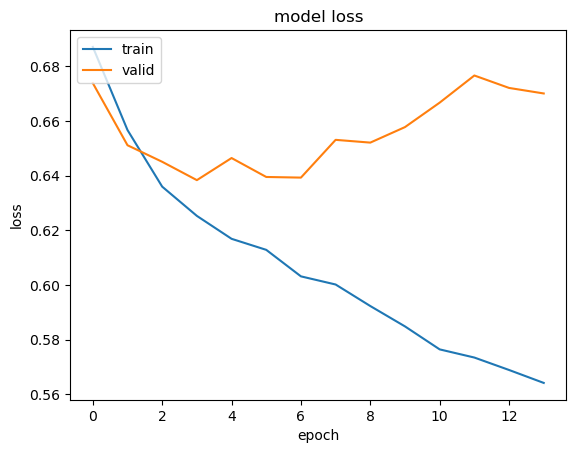

In [25]:
loss = train_history.history["loss"]
var_loss = train_history.history["val_loss"]
plt.plot(loss,label="loss")
plt.plot(var_loss,label="val_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("model loss")
plt.legend(["train","valid"],loc = "upper left")

In [696]:
# results = []

# # COMPUTE BASELINE (NO SHUFFLE)
# oof_preds = regressor.predict(X_test, verbose=0).squeeze() 
# baseline_mae = np.mean(np.abs(oof_preds-y_test))

# results.append({'feature':'BASELINE','mae':baseline_mae})           

# for k in range(len(list(test_X.columns))):
                
#     # SHUFFLE FEATURE K
#     save_col = X_test[:,:,k].copy()
#     np.random.shuffle(X_test[:,:,k])

#     # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
#     oof_preds = regressor.predict(X_test, verbose=0).squeeze() 
#     mae = np.mean(np.abs( oof_preds-y_test ))
#     results.append({'feature':test_X.columns[k],'mae':mae})
#     X_test[:,:,k] = save_col
    
# df = pd.DataFrame(results)
# df = df.sort_values('mae')
# plt.figure(figsize=(10,20))
# plt.barh(np.arange(len(list(test_X.columns))+1),df.mae)
# plt.yticks(np.arange(len(list(test_X.columns))+1),df.feature.values)
# plt.title('LSTM Feature Importance',size=16)
# plt.ylim((-1,len(list(test_X.columns))+1))
# plt.plot([baseline_mae,baseline_mae],[-1,len(list(test_X.columns))+1], '--', color='orange',
#   label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
# plt.xlabel(f'Fold {1} OOF MAE with feature permuted',size=14)
# plt.ylabel('Feature',size=14)
# plt.legend()
# plt.show()

358/358 [==============================] - 1s 690us/step


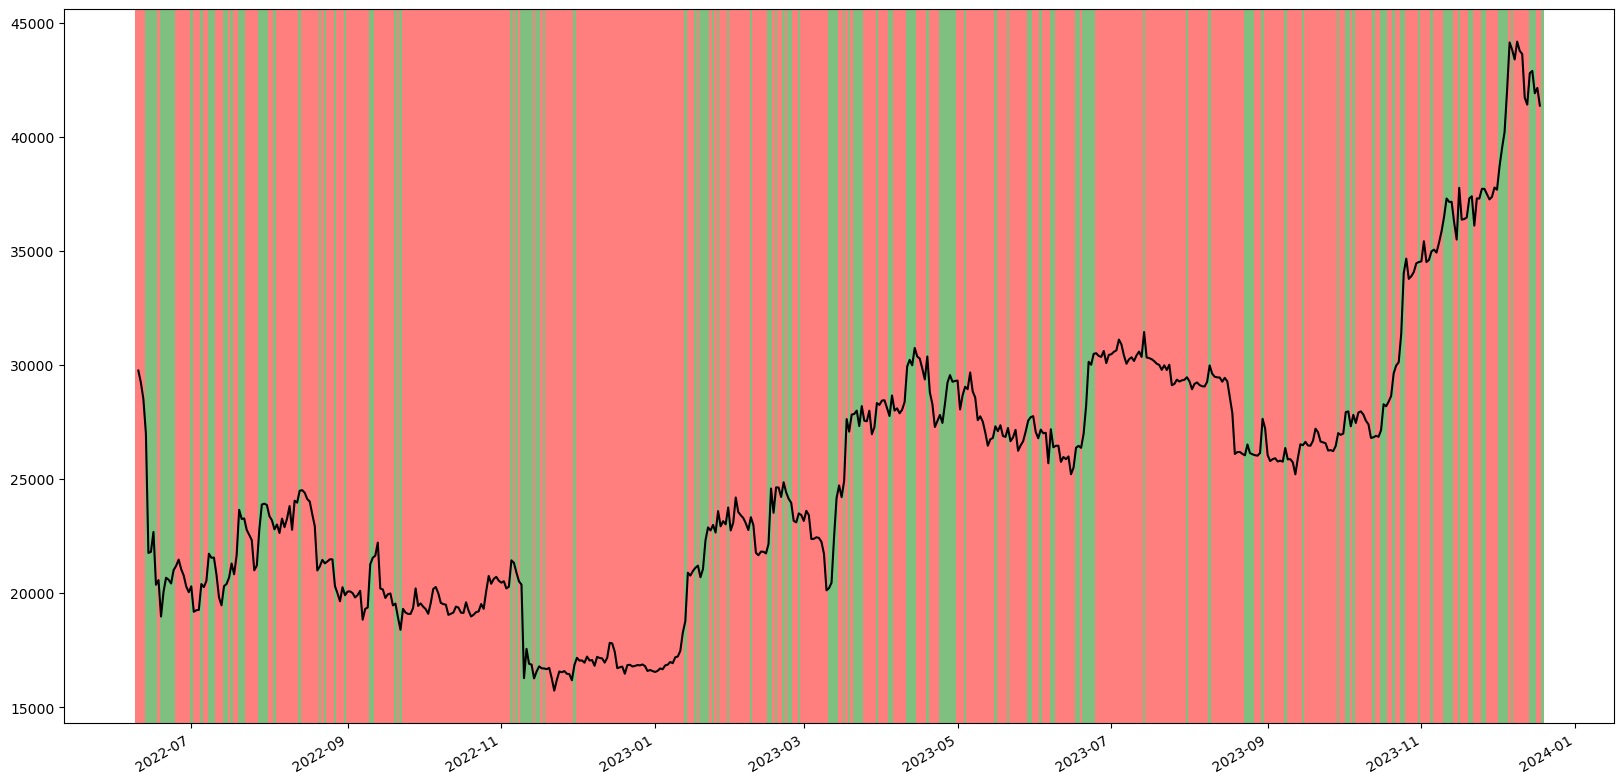

In [20]:
regressor.evaluate(X_test, y_test,verbose=1)

predict_x = regressor.predict(X_test) 
df_predict = pd.DataFrame(predict_x,columns = ["Buy"])
df_predict["Action"] = np.where(df_predict["Buy"] > 0.5, 1, 0)
result = pd.DataFrame({"Close":btcusdt_data.iloc[split:]["Close"]})
result["Real"] = test_y["label"]
result["Predict"] = list(df_predict["Action"])
result["mdate"] = result.index
result['mdate'] = pd.to_datetime(result['mdate'],format='%Y/%m/%d')
result.set_index(result["mdate"],inplace=True)

df = result.copy()
df = df.resample('D').ffill()

t = mdates.drange(df.index[0], df.index[-1], dt.timedelta(hours = 24))
y = np.array(df.Close[:-1])

fig, ax = plt.subplots()
ax.plot_date(t, y, 'b-', color = 'black')
for i in range(len(df)):
    if df.Predict[i] == 1:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'green', edgecolor = 'none', alpha = 0.5
            )
    else:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor = 'red', edgecolor = 'none', alpha = 0.5
            )
fig.autofmt_xdate()
fig.set_size_inches(20,10.5)

In [698]:
# m -> buy and hold -> blue
# s -> strategy -> orange
# a -> actual -> green

<AxesSubplot: xlabel='mdate'>

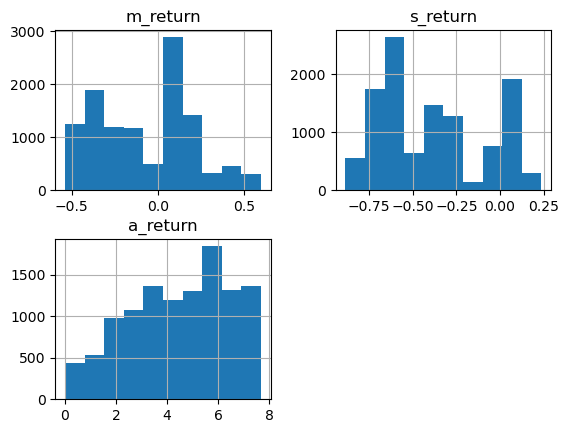

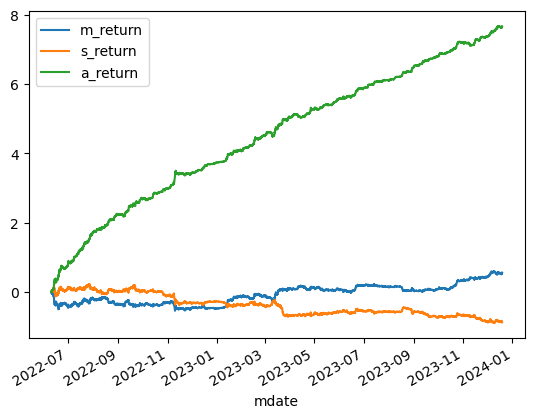

In [21]:
test_data = btcusdt_data.iloc[split:].copy()
backtest = pd.DataFrame(index=result.index)
backtest["r_signal"] = list(test_data["label"])
backtest["p_signal"] = list(result["Predict"])
backtest["m_return"] = list(test_data["Close"].pct_change())

backtest["r_signal"] = backtest["r_signal"].replace(0,-1)
backtest["p_signal"] = backtest["p_signal"].replace(0,-1)
backtest["a_return"] = backtest["m_return"]*backtest["r_signal"].shift(1)
backtest["s_return"] = backtest["m_return"]*backtest["p_signal"].shift(1)
backtest[["m_return","s_return","a_return"]].cumsum().hist()
backtest[["m_return","s_return","a_return"]].cumsum().plot()

# Getting buy and sell signal using local min and max

In [678]:
btcusdt_data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,SMA_10,...,BB_Upper,BB_Middle,BB_Lower,MOM_10,SlowK,SlowD,ADX_14,prev_close,RC,label
Open Time,,,,,,,,,,,,,,,,,,,,,
2018-12-14 23:00:00,3243.84,3247.49,3213.98,3224.17,1170.976343,3.782873e+06,6208,617.026866,1.993580e+06,6932.478,...,7144.136091,6928.1770,6773.514109,-58.81,48.923392,36.083757,44.817205,6934.58,-0.021282,0
2018-12-15 00:00:00,3225.19,3247.96,3213.17,3243.78,1464.353550,4.727841e+06,6888,879.758427,2.840633e+06,6932.478,...,7144.136091,6928.1770,6773.514109,-36.29,57.353549,47.493156,44.817205,6934.58,-0.014402,0
2018-12-15 01:00:00,3244.68,3247.27,3230.00,3234.75,734.809837,2.378950e+06,4689,396.160712,1.282574e+06,6932.478,...,7144.136091,6928.1770,6773.514109,-25.54,54.575506,53.617482,44.817205,6934.58,-0.020951,0
2018-12-15 02:00:00,3234.37,3249.31,3222.42,3241.86,691.391823,2.235618e+06,4503,385.739536,1.247366e+06,6932.478,...,7144.136091,6928.1770,6773.514109,25.79,57.203295,56.377450,44.817205,6934.58,-0.013322,0
2018-12-15 03:00:00,3242.27,3262.00,3240.03,3256.22,822.661121,2.673310e+06,5278,403.326878,1.310944e+06,6932.478,...,7144.136091,6928.1770,6773.514109,41.63,65.364686,59.047829,44.817205,6934.58,-0.015582,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-12 17:00:00,41343.06,41343.07,40700.00,40702.99,3298.589800,1.351429e+08,96753,1499.073420,6.140554e+07,41576.511,...,42195.664328,41593.1945,40990.724672,-517.76,23.742075,26.382986,35.816874,41343.06,-0.026379,1
2023-12-12 18:00:00,40702.99,41421.14,40680.00,41305.44,2334.042350,9.607960e+07,89134,1374.194410,5.657278e+07,41503.369,...,42194.725103,41594.1525,40993.579897,-517.76,26.228684,26.382986,36.024049,40702.99,-0.010299,1
2023-12-12 19:00:00,41305.44,41330.00,41025.00,41137.99,1268.109820,5.221665e+07,50253,640.481100,2.637517e+07,41436.711,...,42203.970051,41588.3820,40972.793949,-517.76,34.389028,26.382986,36.216426,41305.44,-0.005979,1


# ML supervised models


In [679]:
# Initialize the Min-Max scaler
scaler = MinMaxScaler()
columns_to_scale = btcusdt_data.select_dtypes(include=['float64', 'int64']).columns
btcusdt_data[columns_to_scale] = scaler.fit_transform(btcusdt_data[columns_to_scale])

# Determine the split indices
train_split = 0.7
validation_split = 0.3  # The remaining data after the training split

# Calculate the split points
total_length = len(btcusdt_data)
train_index = int(train_split * total_length)

# Split the DataFrame into training and validation sets
train_data = btcusdt_data.iloc[:train_index]
validation_data = btcusdt_data.iloc[train_index:]

# Separate features (X) and target (y) for each split
X_train = train_data.drop(columns=['label'])
y_train = train_data['label'] 

X_validation = validation_data.drop(columns=['label'])
y_validation = validation_data['label'] 

# # Define the start and end timestamps for the first and last weeks, assuming 30 days in a week
# start_timestamp_first_week = X_train.index.min()
# end_timestamp_first_week = start_timestamp_first_week + timedelta(days=7) 

# start_timestamp_last_week = X_train.index.max() - timedelta(days=7)  
# end_timestamp_last_week = X_train.index.max()

# # Select rows corresponding to the first week
# X_first_week = X_train[(X_train.index >= start_timestamp_first_week) &
#                          (X_train.index < end_timestamp_first_week)]

# # Select rows corresponding to the last week
# X_last_week = X_train[(X_train.index >= start_timestamp_last_week) &
#                         (X_train.index <= end_timestamp_last_week)]

# # Extract the indices of rows in X_train that belong to the first week
# indices_first_week = (X_train.index >= start_timestamp_first_week) & (X_train.index < end_timestamp_first_week)

# # Extract the indices of rows in X_train that belong to the last week
# indices_last_week = (X_train.index >= start_timestamp_last_week) & (X_train.index <= end_timestamp_last_week)

# # Use the indices to extract the corresponding y_train entries
# y_first_week = y_train[indices_first_week]
# y_last_week = y_train[indices_last_week]

# # Create an empty list to store the selected features
# selected_features = []

# # Define the evaluation threshold (AUC > 0.5)
# threshold = 0.5

# # Create a tqdm progress bar for the loop
# for feature in tqdm(X_train.columns , desc="Processing Features"):
    
#     # Train a logistic regression model using only the current feature
#     #model = xgb.XGBClassifier()
#     model = lgb.LGBMClassifier(verbose=-1)
#     model.fit(X_first_week[[feature]], y_first_week)
    
#     # Predict on the last week of the training data
#     y_pred = model.predict_proba(X_last_week[[feature]])[:, 1]
    
#     # Calculate AUC for the validation set
#     auc = roc_auc_score(y_last_week, y_pred)
    
#     # Check if AUC is above the threshold
#     if auc > threshold:
#         selected_features.append(feature)

# print('Following',len(X_train.columns) - len(selected_features),'features removed:')
# print(np.array(set(X_train.columns) - set(selected_features)))
# print('#'*70)
# print('Following',len(selected_features),'features selected:')
# print(np.array(selected_features))


# # SMOTE
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
# X_validation, y_validation = smote.fit_resample(X_validation, y_validation)



In [680]:
%%time

# Create an XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=5000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    eval_metric='auc',
    random_state=42,
    verbosity=1  # You can adjust verbosity level as needed
)

# Fit the model to your training data
clf.fit(
    X_train,
    y_train,
    eval_set=[(X_validation, y_validation)],
    early_stopping_rounds=100,  # Early stopping based on the validation set
    verbose=100  # You can adjust the verbosity level as needed
)

# Find the optimal iteration (early stopping)
optimal_iteration = clf.best_iteration
print(f"Optimal iteration: {optimal_iteration}")

# Predict probabilities for the positive class (class 1)
y_pred_proba = clf.predict_proba(X_validation)[:, 1]
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_proba >= pred_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_validation, y_pred)
precision = precision_score(y_validation, y_pred)
recall = recall_score(y_validation, y_pred)
f1 = f1_score(y_validation, y_pred)
roc_auc = roc_auc_score(y_validation, y_pred_proba)
confusion = confusion_matrix(y_validation, y_pred)

# Print the evaluation metrics and confusion matrix
print('ROC AUC Score:', roc_auc, '\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#' * 20, '\n')


[0]	validation_0-auc:0.55630
[100]	validation_0-auc:0.59321
[200]	validation_0-auc:0.59612
[300]	validation_0-auc:0.59594
[362]	validation_0-auc:0.59519
Optimal iteration: 262
ROC AUC Score: 0.5974316593903404 

Accuracy: 0.5543586217434487
Precision: 0.5706735634768919
Recall: 0.7157968970380818
F1 Score: 0.6350497403491209
Confusion Matrix:
[[2181 3818]
 [2015 5075]]
#################### 

CPU times: user 56.6 s, sys: 11.4 s, total: 1min 7s
Wall time: 9.89 s


In [681]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

# We add the imbalance ratio for our scale_pos_weight
# imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# print('Class imbalanace ratio:', round(imbalance_ratio,4))

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=5000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8,
    random_state=42,
#     scale_pos_weight = imbalance_ratio,
)
# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

# Fit the model with callbacks
h = clf.fit(
    X_train,
    y_train,
    eval_set=[(X_validation, y_validation)],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)

# Find the optimal iteration
optimal_iteration = clf.best_iteration_
print(f"Optimal iteration: {optimal_iteration}")

# Predict probabilities for the positive class (class 1)
y_pred_proba = clf.predict_proba(X_validation)[:, 1]
pred_threshold = 0.3

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_proba >= pred_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_validation, y_pred)
precision = precision_score(y_validation, y_pred)
recall = recall_score(y_validation, y_pred)
f1 = f1_score(y_validation, y_pred)
roc_auc = roc_auc_score(y_validation, y_pred_proba)
confusion = confusion_matrix(y_validation, y_pred)

# Print the evaluation metrics and confusion matrix
print('ROC AUC Score:', roc_auc, '\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(confusion)
print('#' * 20, '\n')


LGBoost version: 3.3.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.586003
Early stopping, best iteration is:
[89]	valid_0's auc: 0.587844
Optimal iteration: 89
ROC AUC Score: 0.587843966001856 

Accuracy: 0.5075254030101612
Precision: 0.528951627405143
Recall: 0.8297602256699577
F1 Score: 0.6460575444761696
Confusion Matrix:
[[ 760 5239]
 [1207 5883]]
#################### 

CPU times: user 3.52 s, sys: 1 s, total: 4.52 s
Wall time: 670 ms


In [682]:

# # Create a Logistic Regression model
# clf = LogisticRegression(random_state=42)

# # Fit the model to your training data
# clf.fit(X_train, y_train)

# # Predict probabilities for the positive class (class 1)
# y_pred_proba = clf.predict_proba(X_validation)[:, 1]
# pred_threshold = 0.3

# # Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
# y_pred = (y_pred_proba >= pred_threshold).astype(int)

# # Calculate metrics
# accuracy = accuracy_score(y_validation, y_pred)
# precision = precision_score(y_validation, y_pred)
# recall = recall_score(y_validation, y_pred)
# f1 = f1_score(y_validation, y_pred)
# roc_auc = roc_auc_score(y_validation, y_pred_proba)
# confusion = confusion_matrix(y_validation, y_pred)

# # Print the evaluation metrics and confusion matrix
# print('ROC AUC Score:', roc_auc, '\n')
# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 Score:', f1)
# print('Confusion Matrix:')
# print(confusion)
# print('#' * 20, '\n')
